In [1]:
import pygsp as p

import numpy as np
from numpy.linalg import matrix_rank, inv, pinv
import matplotlib.pyplot as plt

import cv2

from scipy import fft

from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from scipy.optimize import linprog, minimize, Bounds

import pandas as pd

from math import cos, asin, sqrt, pi

from spielman_learning import *

In [2]:
from ripser import ripser
from persim import plot_diagrams

In [3]:
data = pd.read_csv('data/weather/weatherAUS.csv')
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [4]:
geo_locations = dict({ #decimal degrees
                    'Albury': (-36.080477, 146.916280),
                    'BadgerysCreek': (-33.881667, 150.744163),
                    'Cobar': (-31.498333, 145.834444),
                    'CoffsHarbour': (-30.296241, 153.113529),
                    'Moree': (-29.461720, 149.840715),
                    'Newcastle': (-32.919295, 151.779535),
                    'NorahHead': (-33.281667, 151.567778),
                    'NorfolkIsland': (-29.028958, 167.958729),
                    'Penrith': (-33.751079, 150.694168),
                    'Richmond': (-37.820395, 145.002515),
                    'Sydney': (-33.869844, 151.208285),
                    'SydneyAirport': (-33.935309, 151.165582),
                    'WaggaWagga': (-35.115000, 147.367778),
                    'Williamtown': (-32.815000, 151.842778),
                    'Wollongong': (-34.424394, 150.893850),
                    'Canberra': (-35.297591, 149.101268),
                    'Tuggeranong': (-35.420977, 149.092134),
                    'MountGinini': (-35.529744, 148.772540),
                    'Ballarat': (-37.562303, 143.860565),
                    'Bendigo': (-36.758877, 144.282593),
                    'Sale': (-38.105036, 147.064790),
                    'MelbourneAirport': (-37.666951, 144.833493),
                    'Melbourne': (-37.814218, 144.963161),
                    'Mildura': (-34.184726, 142.162497),
                    'Nhil': (-36.333130, 141.649293),
                    'Portland': (-38.345623, 141.604230),
                    'Watsonia': (-37.711002, 145.083635),
                    'Dartmoor': (-27.996162, 115.189218),
                    'Brisbane': (-27.468968, 153.023499),
                    'Cairns': (-16.920666, 145.772185),
                    'GoldCoast': (-28.002373, 153.414599),
                    'Townsville': (-19.256939, 146.823954),
                    'Adelaide': (-34.928181, 138.599931),
                    'MountGambier': (-37.824670, 140.782007),
                    'Nuriootpa': (-34.469335, 138.993901),
                    'Woomera': (-31.199914, 136.825353),
                    'Albany': (-35.024782, 117.883608),
                    'Witchcliffe': (-34.010273, 115.115673),
                    'PearceRAAF': (-31.673960, 116.017544),
                    'PerthAirport': (-31.940610, 115.967608),
                    'Perth': (-31.955896, 115.860580),
                    'SalmonGums': (-32.981535, 121.643942),
                    'Walpole': (-34.977680, 116.731006),
                    'Hobart': (-42.882509, 147.328123),
                    'Launceston': (-41.434081, 147.137350),
                    'AliceSprings': (-23.698388, 133.881289),
                    'Darwin': (-12.460440, 130.841047),
                    'Katherine': (-14.464616, 132.263599),
                    'Uluru': (-25.345554, 131.036961)
                     })

In [5]:
cols = ['Temp3pm', 'Humidity3pm', 'Rainfall']
data_geos = {c: data.dropna(subset = [c])[['Date', 'Location', *cols]] for c in cols}

In [6]:
dates = {c: np.unique(data_geos[c]['Date'].values) for c in cols}

In [7]:
%%time
full_dates = {c: [d for d in dates[c] if len(data_geos[c][data_geos[c]['Date'] == d]) == 49] for c in cols}

CPU times: user 48.7 s, sys: 46.9 ms, total: 48.8 s
Wall time: 49 s


In [8]:
#number of dates where the complete signal is available
len(full_dates[cols[0]]), len(full_dates[cols[1]]), len(full_dates[cols[2]])

(520, 404, 462)

In [9]:
k = 10 #number of observations
rs = np.random.RandomState(12345)
random_indexes = {c: rs.randint(len(full_dates[c]), size = (k, 1)) for c in cols}
random_dates = {c: np.array(full_dates[c])[random_indexes[c]].flatten() for c in cols} 

In [10]:
print(cols[0], ': ', random_dates[cols[0]],'\n' + cols[1] + ': ', random_dates[cols[1]], '\n' + cols[2] + ': ', random_dates[cols[2]]) 

Temp3pm :  ['2014-11-13' '2014-11-17' '2014-03-19' '2013-08-29' '2014-09-07'
 '2014-09-14' '2014-07-28' '2014-06-27' '2013-08-15' '2014-07-11'] 
Humidity3pm:  ['2014-09-17' '2013-11-22' '2013-10-06' '2013-09-16' '2014-05-14'
 '2014-11-22' '2014-02-26' '2014-11-18' '2014-02-18' '2014-06-04'] 
Rainfall:  ['2013-08-13' '2013-12-20' '2013-08-20' '2014-07-31' '2014-02-26'
 '2016-05-18' '2013-06-05' '2014-10-20' '2013-04-15' '2013-04-30']


In [11]:
vertice_labels = {i: data_geos[cols[0]][data_geos[cols[0]]['Date'] == full_dates[cols[0]][0]]['Location'].values[i] for i in range(49)}  
signals = {c: np.array([data_geos[c][data_geos[c]['Date'] == d][c].values for d in random_dates[c]]) for c in cols}

In [12]:
def get_index(place):
    return list(vertice_labels.values()).index(place)

In [13]:
x1 = signals[cols[0]].T
x2 = signals[cols[1]].T
n, d = np.shape(x1)

L0 = np.arange(0, n ** 2, 1).reshape((n, n))/100
# L0 = 0.000005 * np.ones((n, n))
ws = L0[np.triu_indices(np.shape(x1)[0], k = 1)]

g = lambda ws: objective_function_spielman(x1, ws)
h = lambda ws: objective_function_spielman(x2, ws)

In [14]:
%%time
α = 0.1
t = 8
res_temp = minimize(g, ws, bounds = bounds_spielman(len(ws)), constraints = constraints_spielman(n, ws, α), 
               tol = 1 * 10 ** (-t))
# res_hum = minimize(h, ws, bounds = bounds_spielman(len(ws)), constraints = constraints_spielman(n, ws, α), 
#                tol = 1 * 10 ** (-t))

CPU times: user 6min 20s, sys: 93.8 ms, total: 6min 20s
Wall time: 6min 21s


In [15]:
L_temp = make_graph(np.shape(x1)[0], res_temp.x, tol = t)
# L_hum = make_graph(np.shape(x1)[0], res_hum.x, tol = t)
L_temp.set_coordinates([[geo_locations[vertice_labels[i]][1], geo_locations[vertice_labels[i]][0]] for i in range(49)])
# L_hum.set_coordinates([[geo_locations[vertice_labels[i]][1], geo_locations[vertice_labels[i]][0]] for i in range(49)])

Text(0.5, 1.0, 'Learned graph, 90 edges')

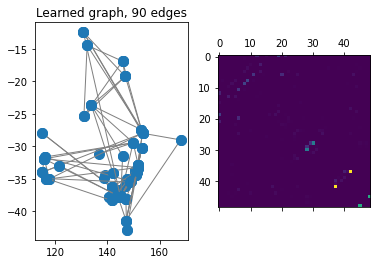

In [16]:
fig, ax = plt.subplots(1, 2)

L_temp.plot(ax = ax[0])
ax[1].matshow(L_temp.W.todense())

ax[0].set_title('Learned graph, ' + str(L_temp.Ne) + ' edges')
# L_temp.plot(ax = ax[1])

In [17]:
# fig, ax = plt.subplots(1, 2)

# ax[0].matshow(L_temp.W.todense())
# ax[1].matshow(L_hum.W.todense())
# ax[0].set_title('Achieved: ' + str(np.round(np.trace(L_temp.L.todense()), 5)) + ', αn: ' + str(α * np.shape(x)[0]))
# ax[1].set_title('Achieved: ' + str(np.round(np.trace(L_hum.L.todense()), 5)) + ', αn: ' + str(α * np.shape(x)[0]))
# plt.show()

In [18]:
L_temp.compute_fourier_basis()
# L_hum.compute_fourier_basis()

In [19]:
ns = [list(n) for n in np.array(np.nonzero(L_temp.W.todense() > 0)).T]

In [20]:
neighbors = dict()
for n in ns:
    i, j = n
    if(vertice_labels[i] in neighbors.keys()):
        neighbors[vertice_labels[i]].append(vertice_labels[j])
    else:
        neighbors[vertice_labels[i]] = [vertice_labels[j]]

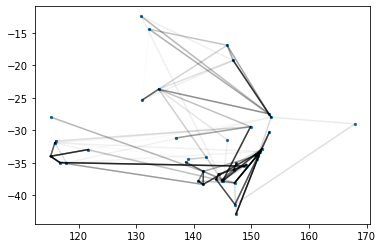

In [21]:
plt.scatter([geo_locations[vertice_labels[i]][1] for i in range(49)], [geo_locations[vertice_labels[i]][0] for i in range(49)], s = 5)
# plt.scatter([geo_locations[vertice_labels[5]][1]], [geo_locations[vertice_labels[5]][0]])

for place in neighbors.keys():
    edges = neighbors[place]
    i = list(vertice_labels.values()).index(place)
    for e in edges:
        j = list(vertice_labels.values()).index(e)
        plt.plot([geo_locations[place][1], geo_locations[e][1]], [geo_locations[place][0], geo_locations[e][0]], color = 'black', alpha = 10 ** (-t + 13) * L_temp.W.todense()[i,j])

In [22]:
distance_weight_ratio = {}
max_ws_ds = {}
for place1 in neighbors.keys():
    i = get_index(place1)
    md, mw = 0, 0
    for place2 in neighbors[place1]:
        j = get_index(place2)
        dist = great_circle_distance(*geo_locations[place1], *geo_locations[place2])
        w = L_temp.W[i, j]
        if place1 not in distance_weight_ratio.keys():
            distance_weight_ratio[place1] = [dist * w]
        else:
            distance_weight_ratio[place1].append(dist * w)            
        if dist > md:
            md = dist
        if w > mw:
            mw = w
    max_ws_ds[place1] = (md, mw)


In [23]:
place_ticks = []
for place in max_ws_ds.keys():
    if max_ws_ds[place][0] * max_ws_ds[place][1] >= 0.08:
        place_ticks += [(get_index(place), place)]

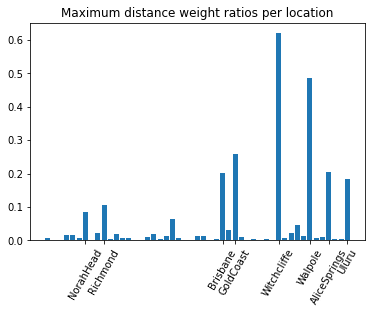

In [24]:
skip = 1
plt.bar(np.arange(49)[::skip], [max_ws_ds[place][0] * max_ws_ds[place][1] for place in max_ws_ds.keys()][::skip])
plt.xticks([p[0] for p in place_ticks], [p[1] for p in place_ticks], rotation = 60)
plt.title('Maximum distance weight ratios per location')
plt.show()

In [25]:
#NorahHead, Richmond, MountGinini, Sale, Cairns, Walpole, AliceSprings, Uluru tem ratios approx 1e-2

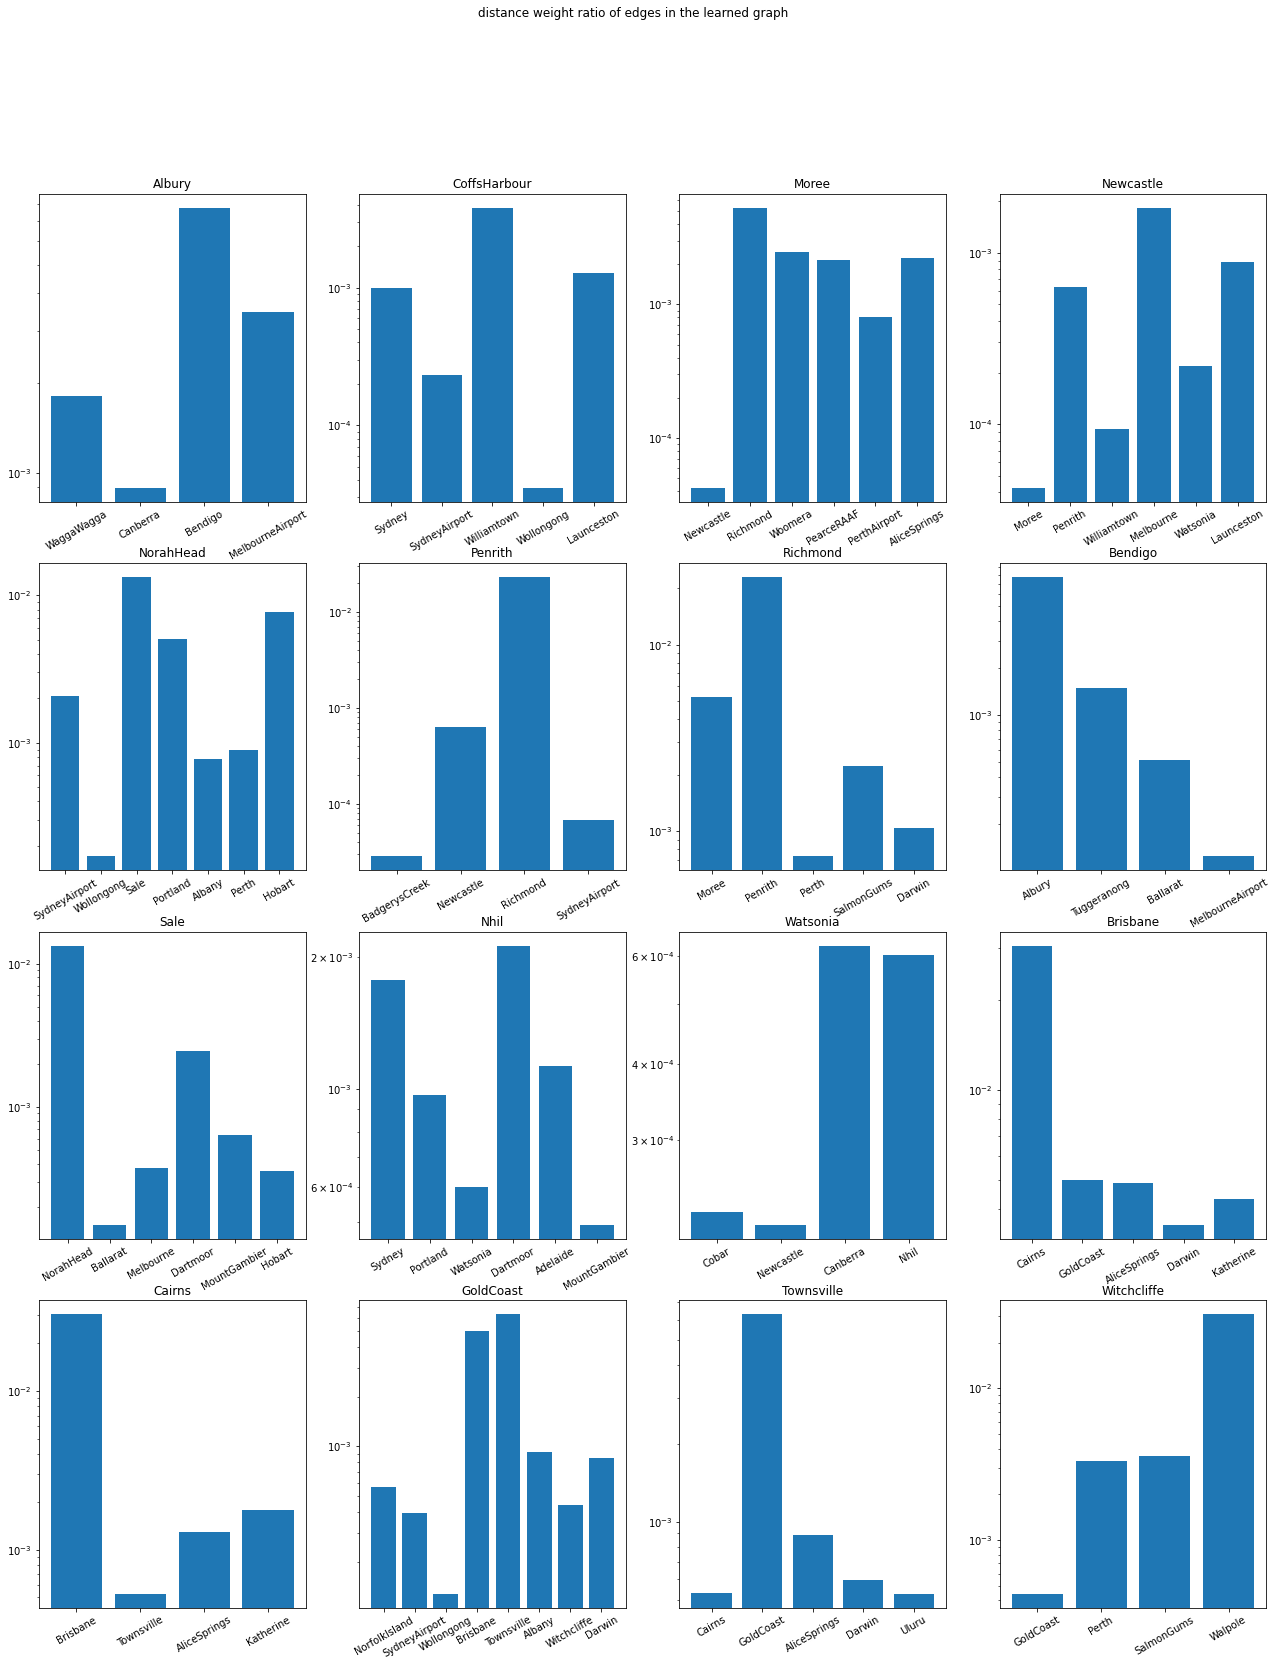

In [26]:
indexes = [0, 3, 4, 5, 6, 8, 9, 19, 20, 24, 26, 28, 29, 30, 31, 37, 38]
places = [vertice_labels[i] for i in indexes]

fig, ax = plt.subplots(4, 4, figsize = (22, 26))
for i in range(4):
    for j in range(4):
        ax[i][j].set_title(places[4 * i + j])
        ax[i][j].bar(np.arange(len(distance_weight_ratio[places[4 * i + j]])), distance_weight_ratio[places[4 * i + j]])
        ax[i][j].set_xticks(np.arange(0, len(neighbors[places[4 * i + j]])))
        ax[i][j].set_xticklabels(neighbors[places[4 * i + j]], rotation = 30)
        ax[i][j].set_yscale('log')
        
fig.suptitle('distance weight ratio of edges in the learned graph')
plt.show()

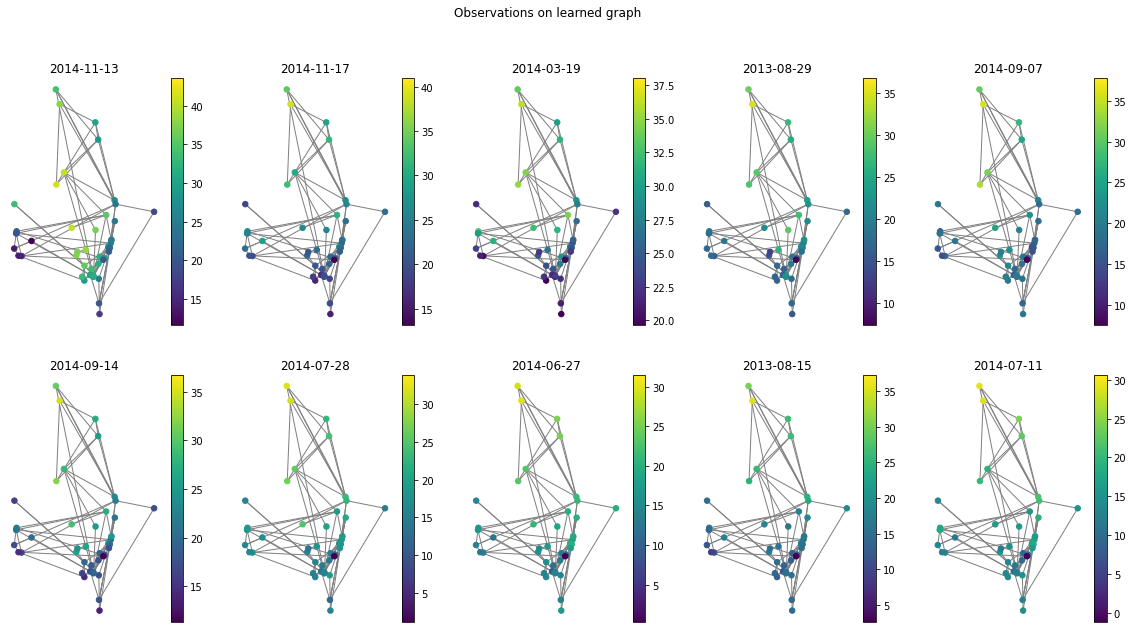

In [27]:
fig, ax = plt.subplots(2, k // 2, figsize = (20, 10))


for i in range(2):
    for j in range(k // 2):
        L_temp.plot_signal(x1.T[i * (k // 2) + j], ax=ax[i][j], vertex_size = 30)
        ax[i][j].set_title(random_dates[cols[0]][i * (k // 2) + j])
        ax[i][j].axis('off')

# for j, i in enumerate([0,5,8]):
#     L_temp.plot_signal(x1.T[i], ax=ax[0][j], vertex_size = 30)
#     ax[1][j].stem(np.abs(L_temp.gft(x1.T[i])))
#     ax[0][j].axis('off')
# #     ax[1][i].axis('off')
#     ax[0][j].set_title(random_dates[cols[0]][i])
#     ax[1][j].set_title('Quadratic laplacian form of x: ' + str(np.round(x1[:, i] @ (L_temp.L) @ x1[:, i], 5)))

# ax[1][0].set_ylabel('Magnitude of coefficients in the GFT')    
plt.suptitle('Observations on learned graph')
plt.show()

In [28]:
normalize = np.sqrt(np.diag(1 / np.diagonal(L_temp.L.todense())))

In [29]:
L_temp.L_normalized = normalize @ L_temp.L @ normalize

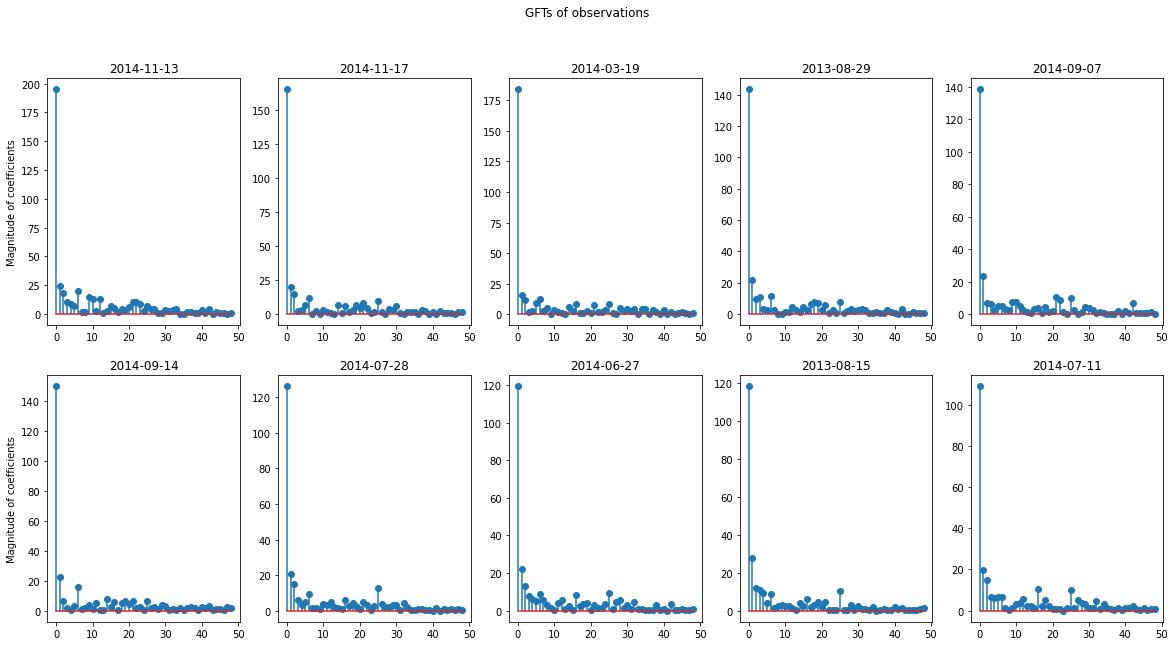

In [30]:
fig, ax = plt.subplots(2, k // 2, figsize = (20, 10))

for i in range(2):
    ax[i][0].set_ylabel('Magnitude of coefficients')
    for j in range(k // 2):
        ax[i][j].stem(np.abs(L_temp.gft(x1.T[i * (k // 2) + j])))
        ax[i][j].set_title(random_dates[cols[0]][i * (k // 2) + j])
        
fig.suptitle('GFTs of observations')
plt.show()

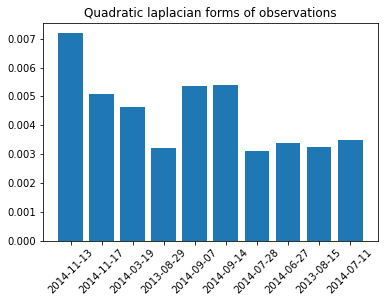

In [31]:
plt.bar(np.arange(k), [x1[:, i] @ (L_temp.L) @ x1[:, i] for i in range(k)])
plt.xticks(np.arange(k),random_dates[cols[0]], rotation = 45)
plt.title('Quadratic laplacian forms of observations')
plt.show()

In [32]:
L_temp.is_connected()

True

In [33]:
# date = '2015-10-15'
# missing_temperatures = {'Newcastle': 26.1, 'Melbourne': 34, 'Albany': 14, 'Katherine': 36.5} 
# #Melbourne entre 29-34, Albany entre 14 e 17 e Katherine entre 35 e 38